https://www.kaggle.com/rakeshrau/social-network-ads

https://pennylane.ai/qml/demos/quantum_neural_net.html#quantum-neural-net

In [1]:
# from sklearn.neural_network import MLPClassifier

In [2]:
# clf = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic').fit(X_train, y_train)

# QNN 

In [22]:
# import libraries
from Qsun.Qcircuit import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

# one layer with full entanglement
def layer(circuit, params):
    circuit_layer = circuit
    n_qubit = len(params)
    for i in range(n_qubit):
        RX(circuit_layer, i, params[i][0])
        RY(circuit_layer, i, params[i][1])
    for i in range(n_qubit-1):
        CNOT(circuit_layer, i, i+1)
    CNOT(circuit_layer, n_qubit-1, 0)
    return circuit_layer

# encoding the features
def initial_state(sample):
    circuit_initial = Qubit(len(sample))
    ampli_vec = np.array([np.sqrt(sample[0]), np.sqrt(1-sample[0])])
    for i in range(1, len(sample)):
        ampli_vec = np.kron(ampli_vec, np.array([np.sqrt(sample[i]), np.sqrt(1-sample[i])]))
    circuit_initial.amplitude = ampli_vec
    return circuit_initial

# QNN circuit
def qnn(circuit, params):
    n_layer = len(params)
    circuit_qnn = circuit
    for i in range(n_layer):
        circuit_qnn = layer(circuit_qnn, params[i])
    return circuit_qnn

# QNN model
def qnn_model(sample, params):
    circuit_model = initial_state(sample)
    circuit_model = qnn(circuit_model, params)
    return circuit_model

# activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-10*x))

# make a prediction
def predict(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    pred = sigmoid(expval_0-expval_1)
    return [pred, 1-pred]

# loss function    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - p[l]) ** 2
    loss = loss / len(labels)
    return loss

# loss function of QNN
def cost(params, features, labels):
    preds = [predict(qnn_model(x, params)) for x in features]
    return square_loss(labels, preds)

# gradient descent with QDP
def grad(X_true, y_true, params, shift, eta):
    diff = np.zeros((n_layer, len(X_train[0]), 2,))
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                params_1 = params.copy()
                params_2 = params.copy()
                params_1[i][j][k] += shift
                params_2[i][j][k] -= shift
                for x, y in zip(X_true, y_true):
                    circuit = qnn_model(x, params)
                    circuit_1 = qnn_model(x, params_1)
                    circuit_2 = qnn_model(x, params_2)
                    pred = predict(circuit)
                    diff[i][j][k] += ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])*(predict(circuit_1)[y]-predict(circuit_2)[y])/(2*np.sin(shift))
    diff = diff/len(y_true)                
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                params[i][j][k] = params[i][j][k] - eta*diff[i][j][k]
                
    return params

#source: https://www.kaggle.com/rakeshrau/social-network-ads
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# scaling feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create parameters  
n_layer = 3
params = np.zeros((n_layer, len(X_train[0]), 2,))
costs_train = []
costs_test = []
costs_train.append(cost(params, X_train, y_train))
costs_test.append(cost(params, X_test, y_test))

# training model
start = time.time()
for i in range(400):
    params = grad(X_train, y_train, params, np.pi/20, eta=0.1)
    costs_train.append(cost(params, X_train, y_train))
    costs_test.append(cost(params, X_test, y_test))
    if costs_train[-1] >= costs_train[-2]:
        break
print(time.time()-start)

# confusion matrix
# label = y_train
# pred = [predict(qnn_model(x, params)) for x in X_train]
# con = confusion_matrix(label,pred)
# sn.heatmap(con, annot=True, cmap="Blues")

153.22109174728394


In [23]:
SIZE = 34*1.3
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


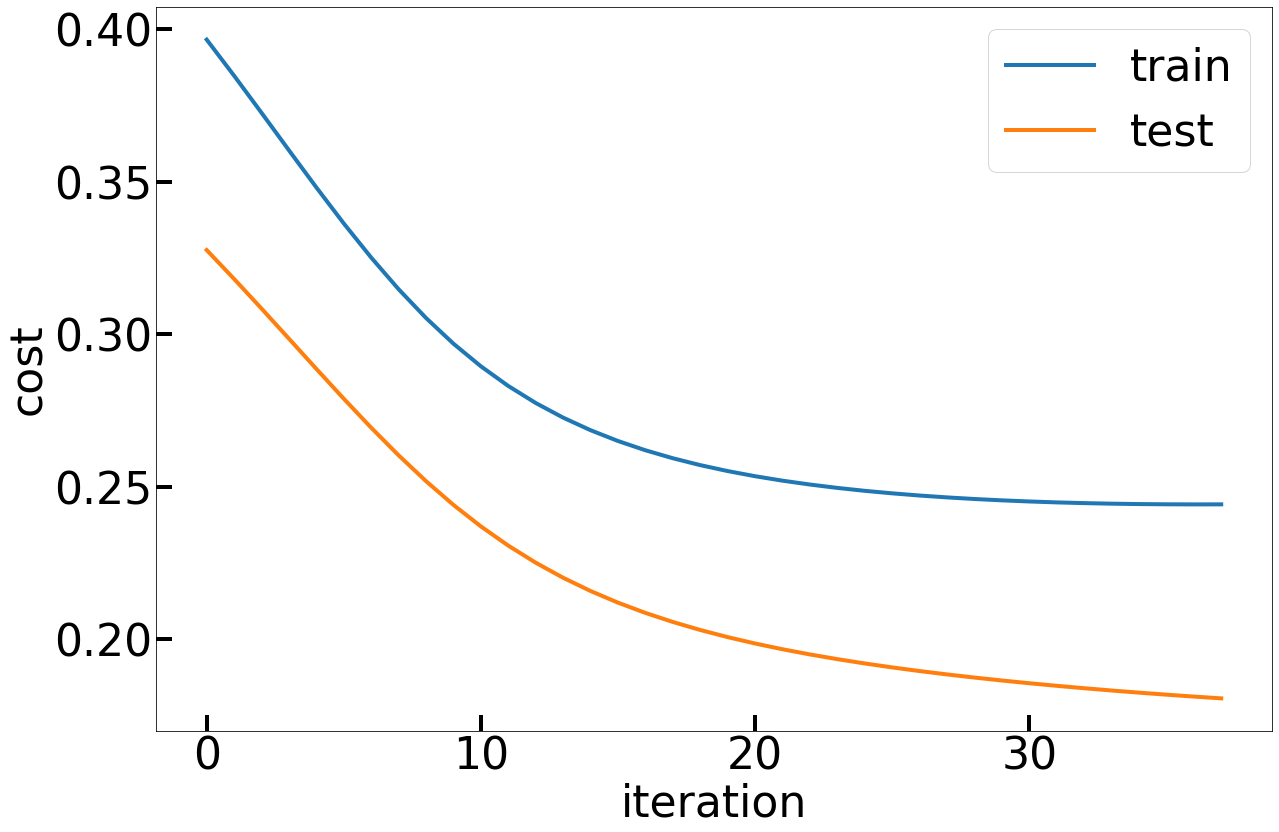

In [27]:
plt.figure(figsize=(20,13.33))
plt.plot(range(len(costs_train)), costs_train, linewidth=4, label='train')
plt.plot(range(len(costs_test)), costs_test, linewidth=4, label='test')
plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
# plt.yscale('log')
plt.xlabel('iteration')
plt.legend(loc='upper right')
plt.ylabel('cost')
plt.savefig('training_time_qnn.png')
plt.savefig('training_time_qnn.eps', format='eps')

In [28]:
costs_train[-1]

0.2442348668953159

In [29]:
costs_test[-1]

0.18060239001273282

In [30]:
# params = np.random.normal(size=(n_layer, len(X_train[0]), 2,))
preds = np.array([predict(qnn_model(x, params)) for x in X_test])
# np.argmax(preds, axis=1)
np.argmax(preds, axis=1)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [31]:
cost(params, X_train, y_train)

0.2442348668953159

In [32]:
params

array([[[ 0.        ,  0.23546266],
        [ 0.        , -0.22678121]],

       [[ 0.        , -0.20207515],
        [ 0.        , -0.01039245]],

       [[ 0.        ,  0.03917809],
        [ 0.        ,  0.20602403]]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


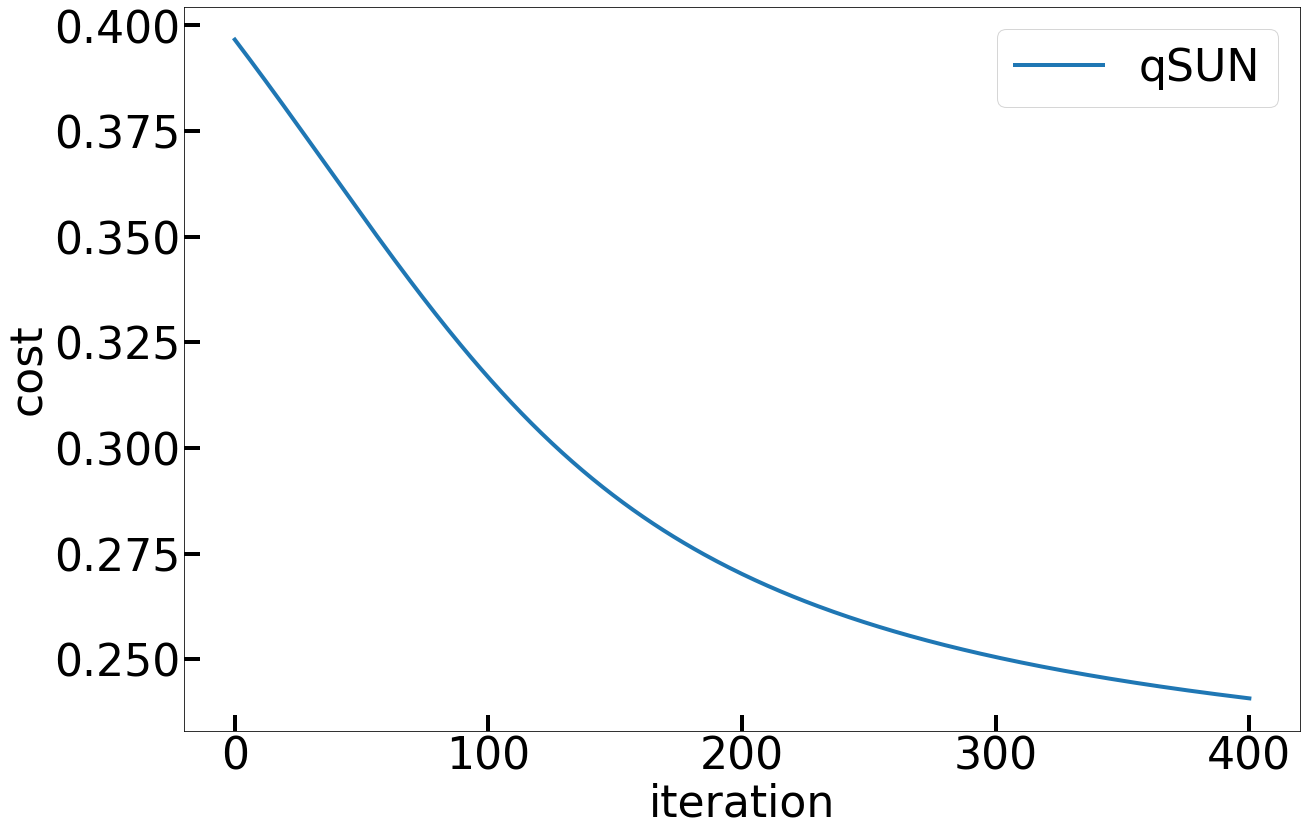

In [23]:
plt.figure(figsize=(20,13.33))
plt.plot(range(len(costs)), costs, linewidth=4, label='qSUN')
plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
# plt.yscale('log')
plt.xlabel('iteration')
plt.legend(loc='upper right')
plt.ylabel('cost')
plt.savefig('training_time_qnn.png')
plt.savefig('training_time_qnn.eps', format='eps')

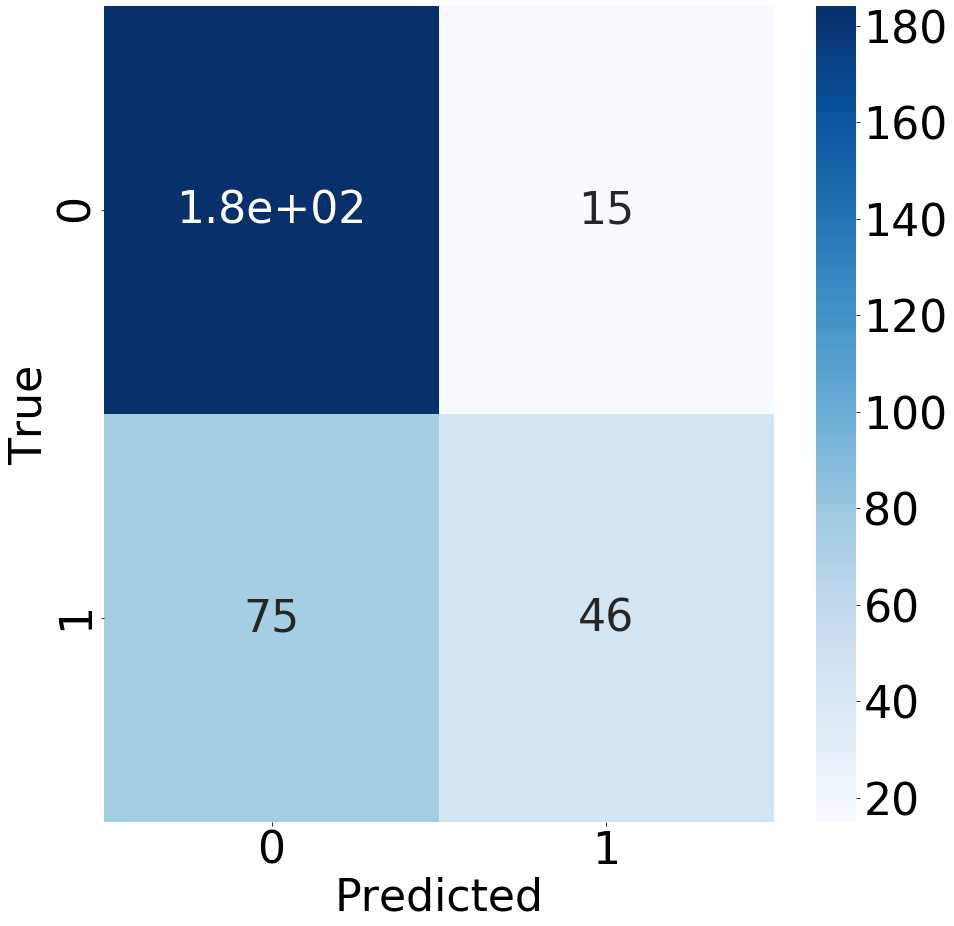

In [33]:
plt.figure(figsize=(15, 15))
label = y_train
pred = [predict(qnn_model(x, params)) for x in X_train]
pred = np.argmax(pred, axis=1)
con = confusion_matrix(label,pred)
sn_plot = sn.heatmap(con, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('qnn_train.png')
plt.savefig('qnn_train.eps', format='eps')

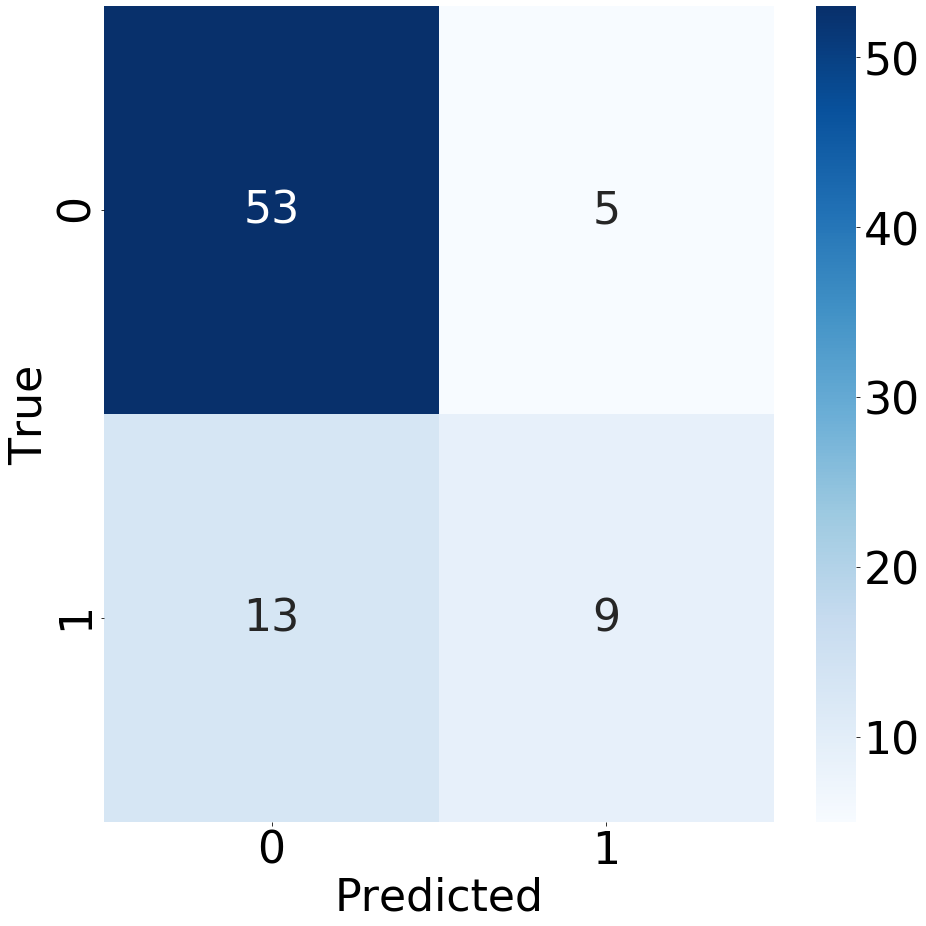

In [34]:
plt.figure(figsize=(15,15))
label = y_test
pred = [predict(qnn_model(x, params)) for x in X_test]
pred = np.argmax(pred, axis=1)
con = confusion_matrix(label,pred)
sn_plot = sn.heatmap(con, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('qnn_test.png')
plt.savefig('qnn_test.eps', format='eps')

# New version

In [1]:
from Qsun.Qcircuit import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
import time

In [3]:
# one layer with full entanglement
def layer(circuit, params):
    circuit_layer = circuit
    n_qubit = len(params)
    for i in range(n_qubit):
        RX(circuit_layer, i, params[i][0])
        RY(circuit_layer, i, params[i][1])
    for i in range(n_qubit-1):
        CNOT(circuit_layer, i, i+1)
    CNOT(circuit_layer, n_qubit-1, 0)
    return circuit_layer

# encoding the features
def initial_state(sample):
    circuit_initial = Qubit(len(sample))
    ampli_vec = np.array([np.sqrt(sample[0]), np.sqrt(1-sample[0])])
    for i in range(1, len(sample)):
        ampli_vec = np.kron(ampli_vec, np.array([np.sqrt(sample[i]), np.sqrt(1-sample[i])]))
    circuit_initial.amplitude = ampli_vec
    return circuit_initial

# QNN circuit
def qnn(circuit, params):
    n_layer = len(params)
    circuit_qnn = circuit
    for i in range(n_layer):
        circuit_qnn = layer(circuit_qnn, params[i])
    return circuit_qnn

# QNN model
def qnn_model(sample, params):
    circuit_model = initial_state(sample)
    circuit_model = qnn(circuit_model, params)
    return circuit_model

# activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# make a prediction
def predict(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    if sigmoid(expval_0) > sigmoid(expval_1):
        return 1
    else:
        return 0

# loss function    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

# loss function of QNN
def cost(params, features, labels):
    preds = [predict(qnn_model(x, params)) for x in features]
    return square_loss(labels, preds)

# gradient descent with QDP
def grad(X_true, y_true, params, shift, eta):
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                params_1 = params.copy()
                params_2 = params.copy()
                params_1[i][j][k] += shift
                params_2[i][j][k] -= shift
                diff[i][j][k] = (cost(params_1, X_true, y_true)
                                 -cost(params_2, X_true, y_true))/(2*np.sin(shift))
                    
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                params[i][j][k] = params[i][j][k] - eta*diff[i][j][k]
                
    return params

In [15]:
#source: https://www.kaggle.com/rakeshrau/social-network-ads
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# scaling feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create parameters  
n_layer = 3
# params = np.random.normal(size=(n_layer, len(X_train[0]), 2,))
params = np.zeros((n_layer, len(X_train[0]), 2,))
diff = np.zeros((n_layer, len(X_train[0]), 2,))
costs = []
costs.append(cost(params, X_train, y_train))

# training model
start = time.time()
for i in range(1000):
    params = grad(X_train, y_train, params, np.pi/20, eta=0.01)
    costs.append(cost(params, X_train, y_train))
print(time.time()-start)

# confusion matrix
# label = y_train
# pred = [predict(qnn_model(x, params)) for x in X_train]
# con = confusion_matrix(label,pred)
# sn.heatmap(con, annot=True, cmap="Blues")

2847.1460638046265


In [16]:
# params = np.zeros((n_layer, len(X_train[0]), 2,))
cost(params, X_train, y_train)

0.184375

In [21]:
params

array([[[-0.89857828, -1.40007439],
        [ 0.14844718,  0.26955701]],

       [[-0.76878714, -0.83009616],
        [-0.42015035, -0.63012408]],

       [[ 1.76053475, -0.13586779],
        [-0.88660507, -0.3680867 ]]])

In [17]:
SIZE = 34*1.3

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


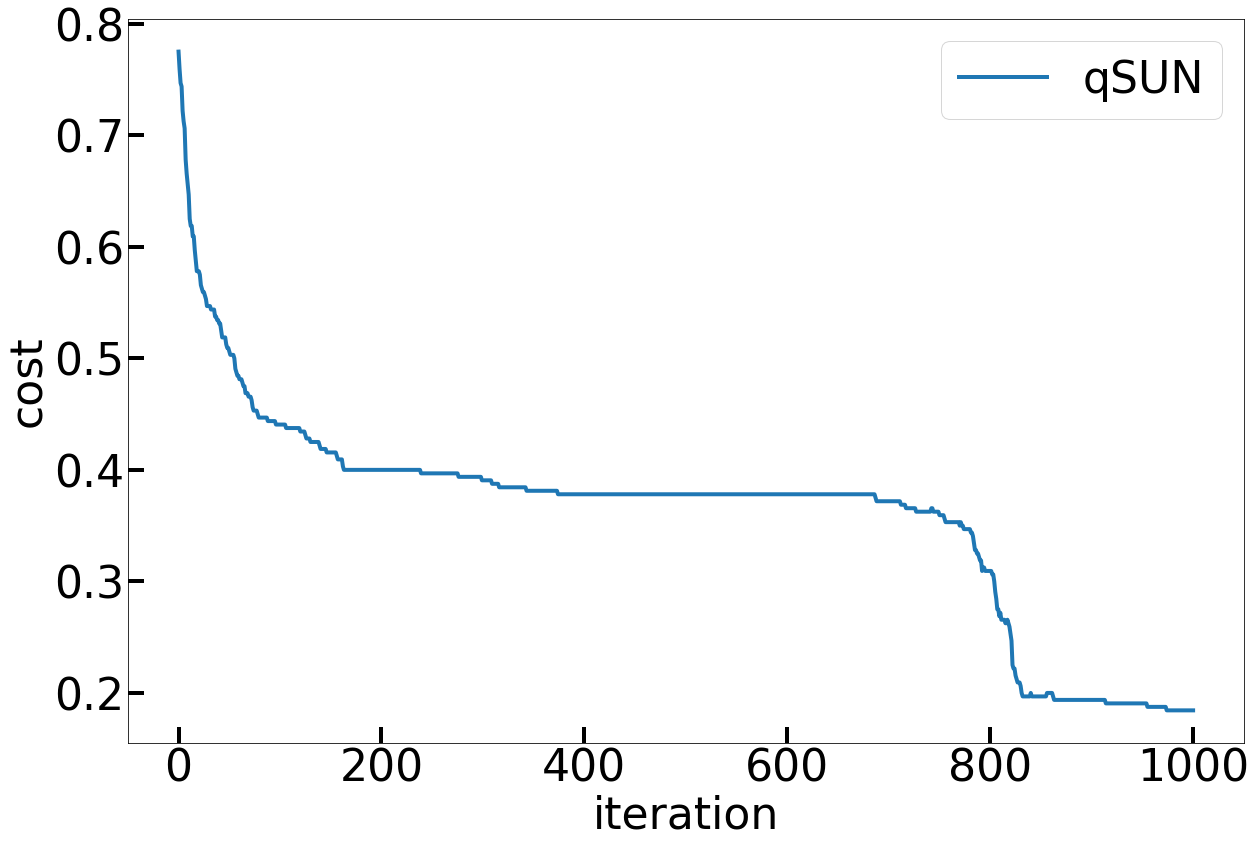

In [18]:
plt.figure(figsize=(20,13.33))
plt.plot(range(0, 1001), costs, linewidth=4, label='qSUN')
plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
# plt.yscale('log')
plt.xlabel('iteration')
plt.legend(loc='upper right')
plt.ylabel('cost')
plt.savefig('training_time_qnn.png')
plt.savefig('training_time_qnn.eps', format='eps')

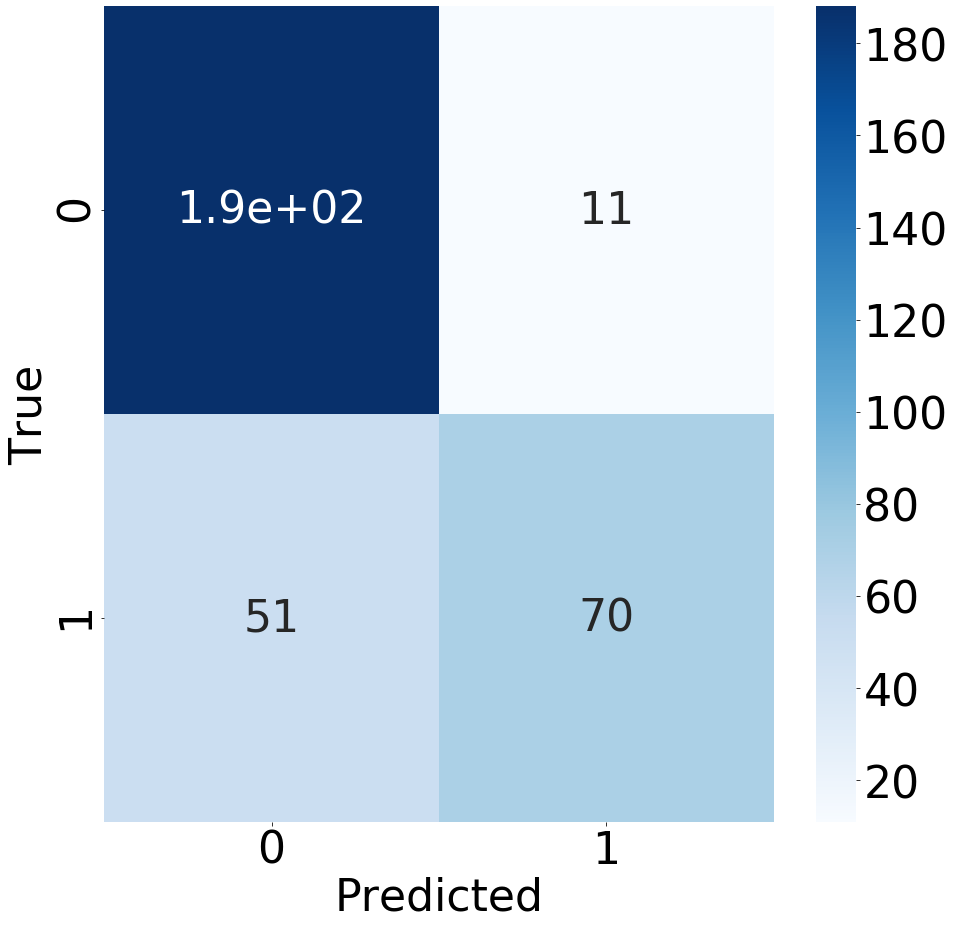

In [10]:
# confusion matrix
plt.figure(figsize=(15, 15))
label = y_train
pred = [predict(qnn_model(x, params)) for x in X_train]
con = confusion_matrix(label,pred)
sn_plot = sn.heatmap(con, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('qnn_train.png')
plt.savefig('qnn_train.eps', format='eps')

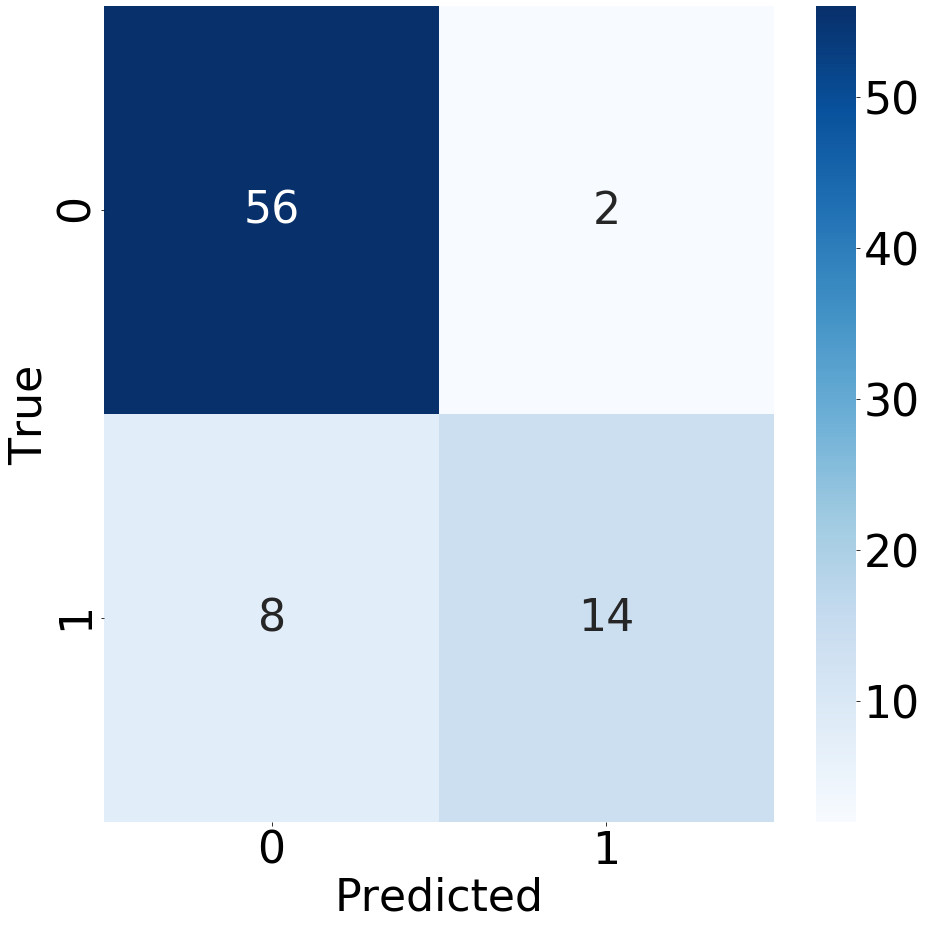

In [11]:
# confusion matrix
plt.figure(figsize=(15,15))
label = y_test
pred = [predict(qnn_model(x, params)) for x in X_test]
con = confusion_matrix(label,pred)
sn_plot = sn.heatmap(con, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('qnn_test.png')
plt.savefig('qnn_test.eps', format='eps')

In [8]:
np.argmax(np.array([0, 3, 2, 3]))

1

In [6]:
277.5062129497528/60

4.625103549162547

In [16]:
n_layer = 3
n_features = 4
params = np.random.normal(size=(n_layer, n_features, 2,))
features = np.random.uniform(0, 1, n_features)

In [17]:
circuit = qnn_model(features, params)

In [20]:
circuit.visual_circuit()

|Q_0> : RX-RY-------------------o--------x--RX-RY-------------------o--------x--RX-RY-------------------o--------x---M
                                |        |                          |        |                          |        |    
|Q_1> : ------RX-RY-------------x--o--------------RX-RY-------------x--o--------------RX-RY-------------x--o---------M
                                   |     |                             |     |                             |     |    
|Q_2> : ------------RX-RY----------x--o-----------------RX-RY----------x--o-----------------RX-RY----------x--o------M
                                      |  |                                |  |                                |  |    
|Q_3> : ------------------RX-RY-------x--o--------------------RX-RY-------x--o--------------------RX-RY-------x--o---M
                                                                                                                      
